## **1 . Import necessary libraries**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline
import random
import os
import warnings
warnings.filterwarnings('ignore')


import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## **2. Load the dataset**

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayaelj","key":"69df13f28fdec99d0b8369cc9bbbcf03"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 600M/612M [00:05<00:00, 164MB/s]
100% 612M/612M [00:05<00:00, 119MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('gtsrb-german-traffic-sign.zip', 'r')
zip_ref.extractall('/content/gtsrb-german-traffic-sign')
zip_ref.close()

## **3. EDA and Preprocessing**

In [10]:
data_dir = "/content/gtsrb-german-traffic-sign"
train_path = '/content/gtsrb-german-traffic-sign/Train'
test_path = '/content/gtsrb-german-traffic-sign/Test'

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [11]:
## Number of Classes
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [12]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

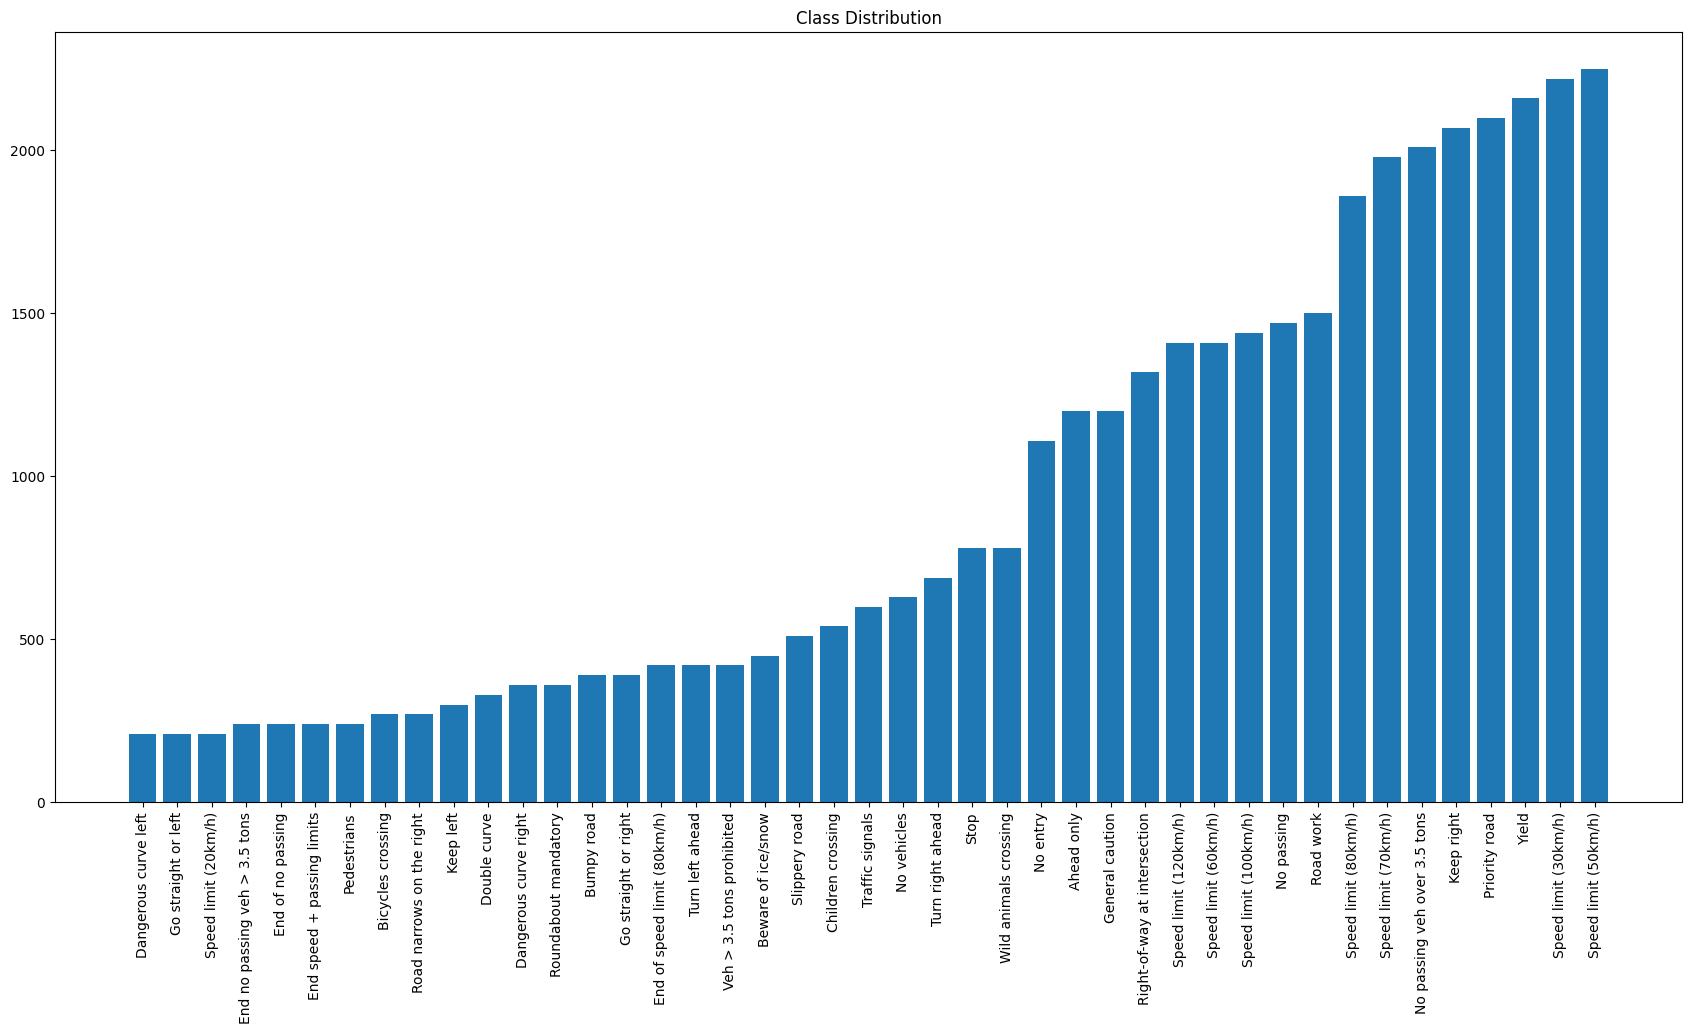

In [42]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.title("Class Distribution")
plt.show()

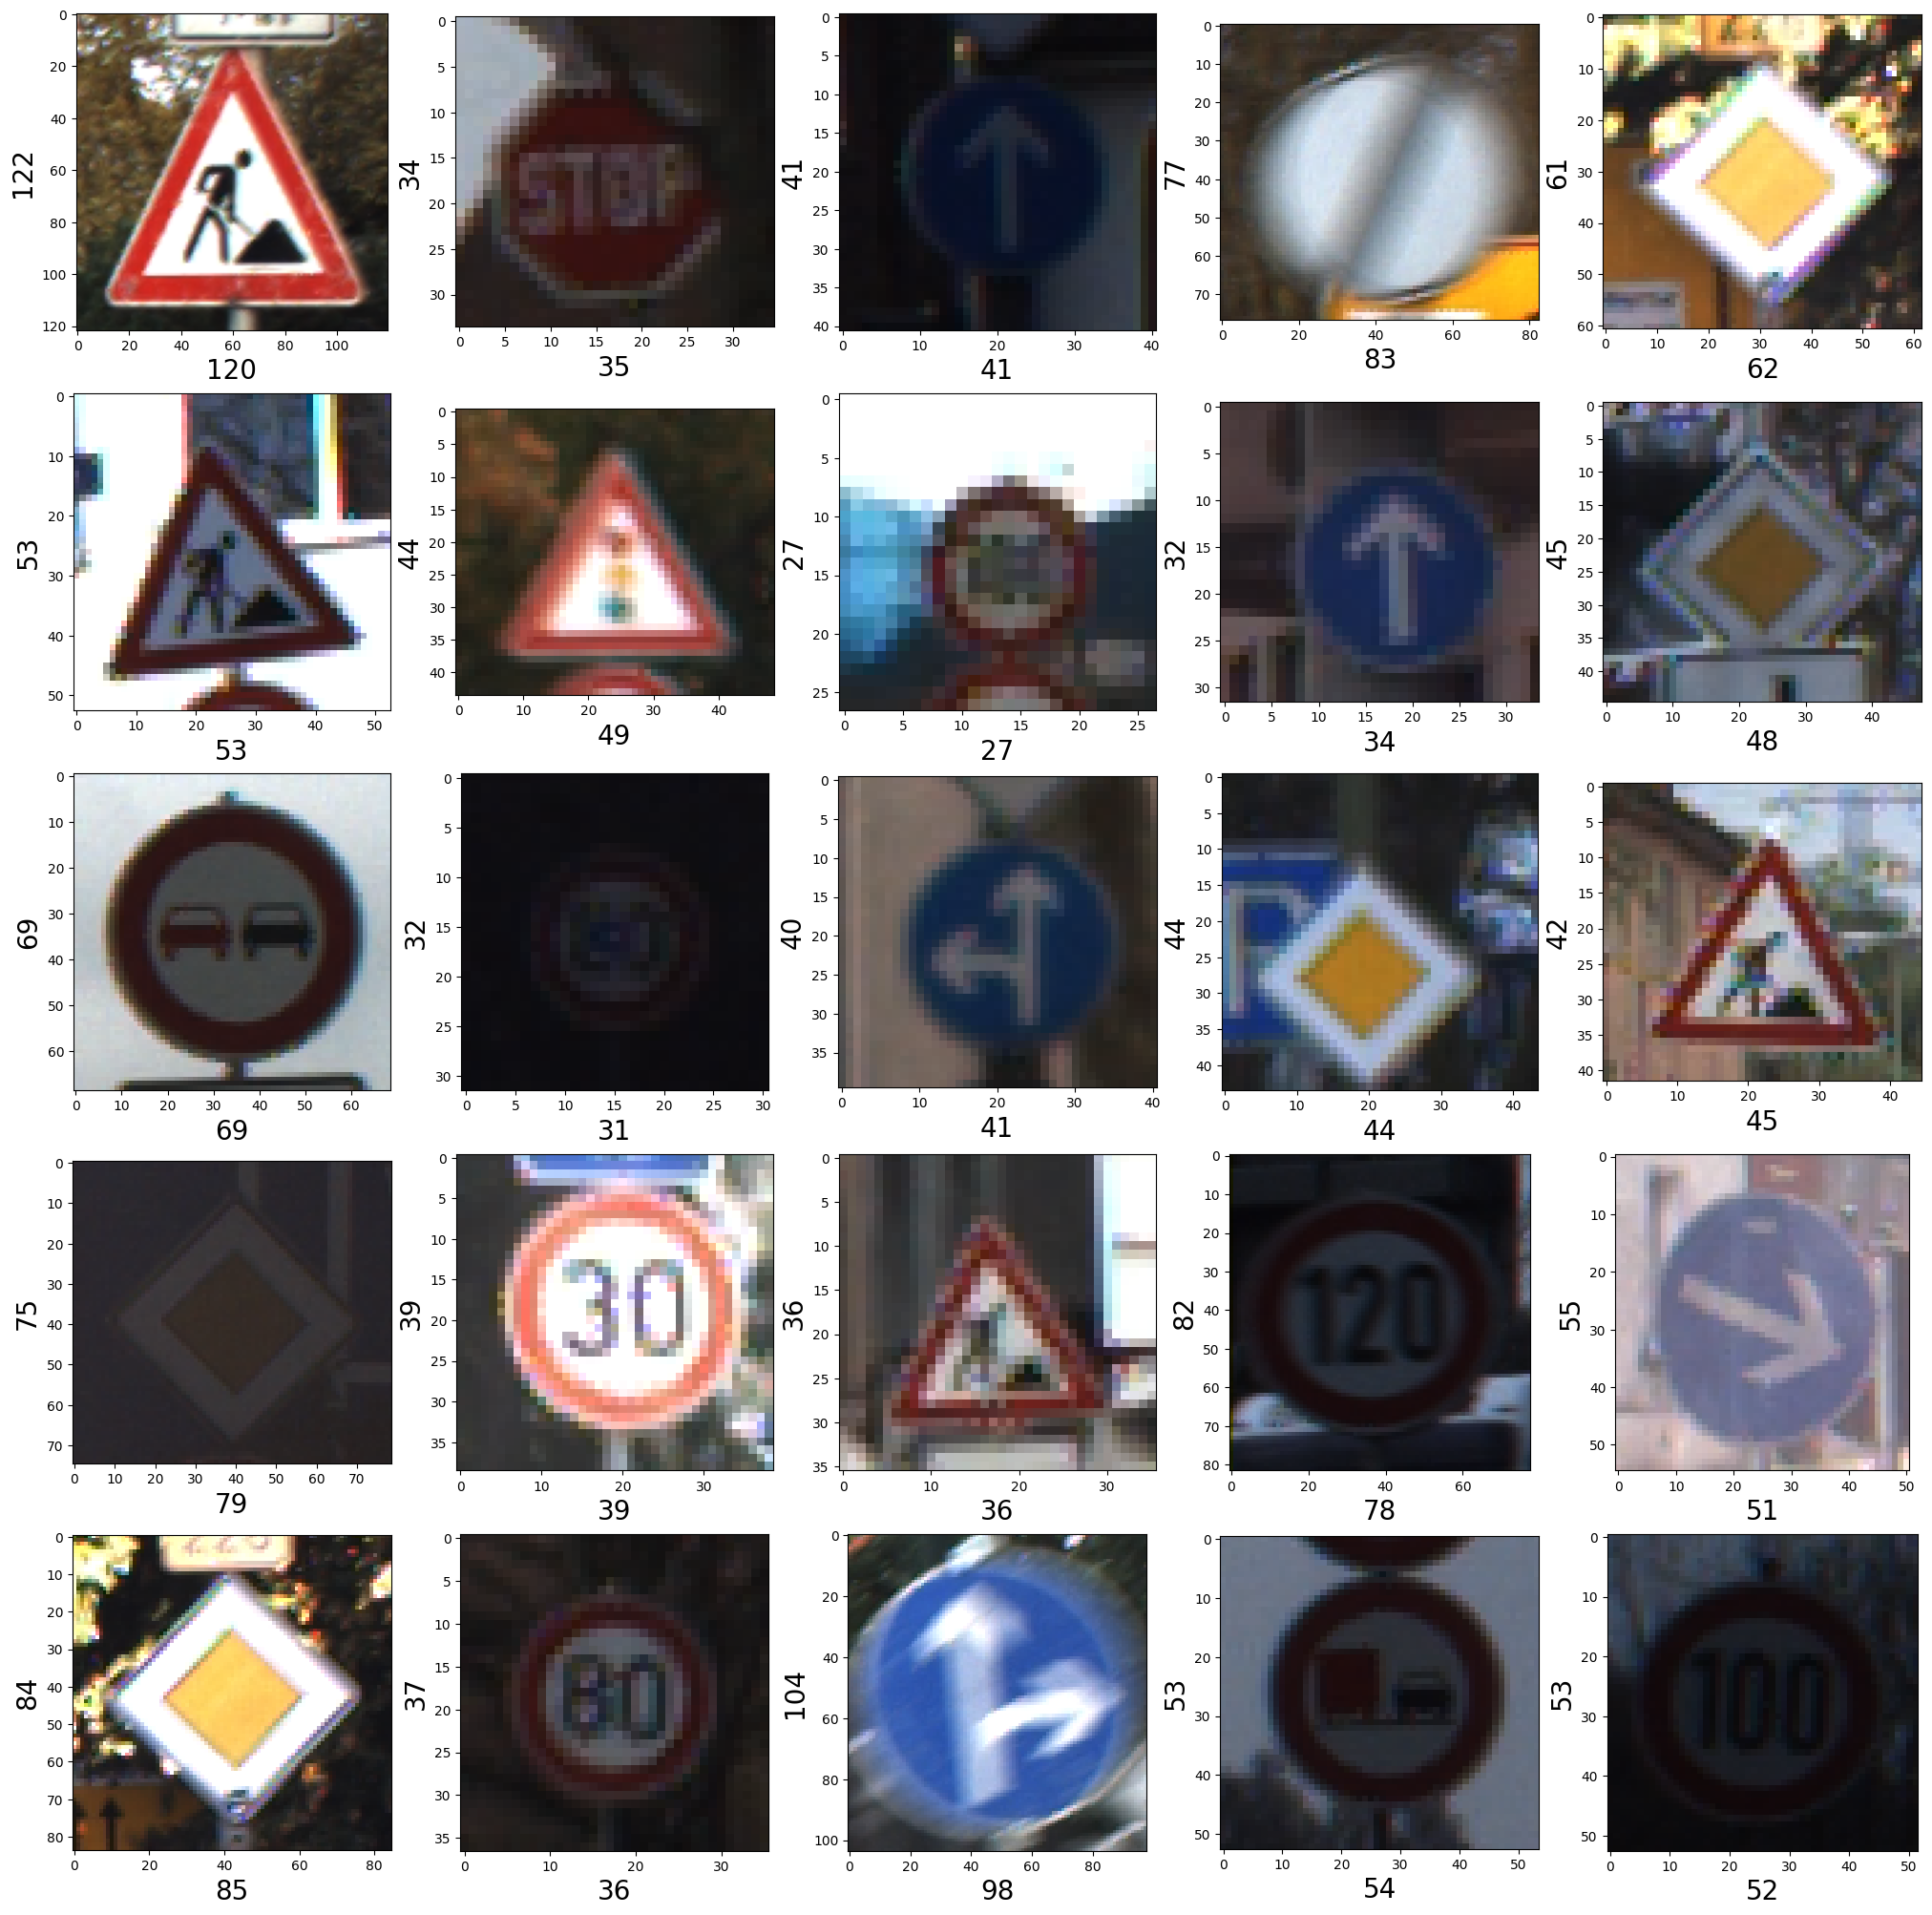

In [16]:
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)
    plt.xlabel(rand_img.shape[1], fontsize = 20)
    plt.ylabel(rand_img.shape[0], fontsize = 20)

In [17]:
## Gathering the Training Data
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [18]:
## Shuffling the training data
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## **4. Model Building**



In [19]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [20]:
## One hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [22]:
# Model Building
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

In [31]:
lr = 0.001
epochs = 30

lr_schedule = ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps = X_train.shape[0] * epochs,
    decay_rate = lr / (epochs * 0.5)
)

opt = Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Data Augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 24s 24ms/step - loss: 0.9203 - accuracy: 0.7447 - val_loss: 0.1315 - val_accuracy: 0.9591
Epoch 2/30
858/858 [==============================] - 21s 24ms/step - loss: 0.1709 - accuracy: 0.9480 - val_loss: 0.0385 - val_accuracy: 0.9869
Epoch 3/30
858/858 [==============================] - 21s 25ms/step - loss: 0.1049 - accuracy: 0.9684 - val_loss: 0.1685 - val_accuracy: 0.9407
Epoch 4/30
858/858 [==============================] - 19s 23ms/step - loss: 0.0884 - accuracy: 0.9732 - val_loss: 0.0675 - val_accuracy: 0.9821
Epoch 5/30
858/858 [==============================] - 21s 24ms/step - loss: 0.0674 - accuracy: 0.9799 - val_loss: 0.0187 - val_accuracy: 0.9947
Epoch 6/30
858/858 [==============================] - 20s 23ms/step - loss: 0.0631 - accuracy: 0.9812 - val_loss: 0.0956 - val_accuracy: 0.9731
Epoch 7/30
858/858 [==============================] - 20s 24ms/step - loss: 0.0612 - accuracy: 0.9817 - val_loss: 0.0176 - val_accuracy:

## **5. Model Evaluation**

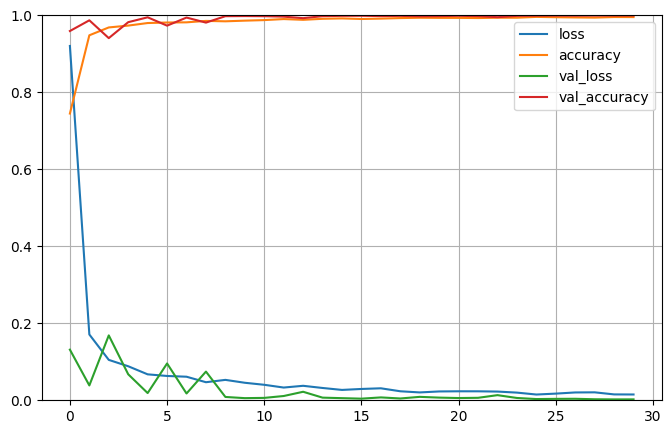

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [35]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred_probs = model.predict(X_test)

pred = np.argmax(pred_probs, axis=1)

print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 1s 2ms/step
Test Data accuracy:  98.66983372921615


In [36]:
## Classification report
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.99      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       0.98      0.98      0.98       450
           4       1.00      1.00      1.00       660
           5       0.99      1.00      0.99       630
           6       0.99      1.00      1.00       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       0.99      1.00      0.99       480
          10       1.00      0.99      1.00       660
          11       0.94      1.00      0.97       420
          12       1.00      0.95      0.98       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.95      1.00      0.97       210
          16       0.99      1.00      1.00       150
          17       1.00    

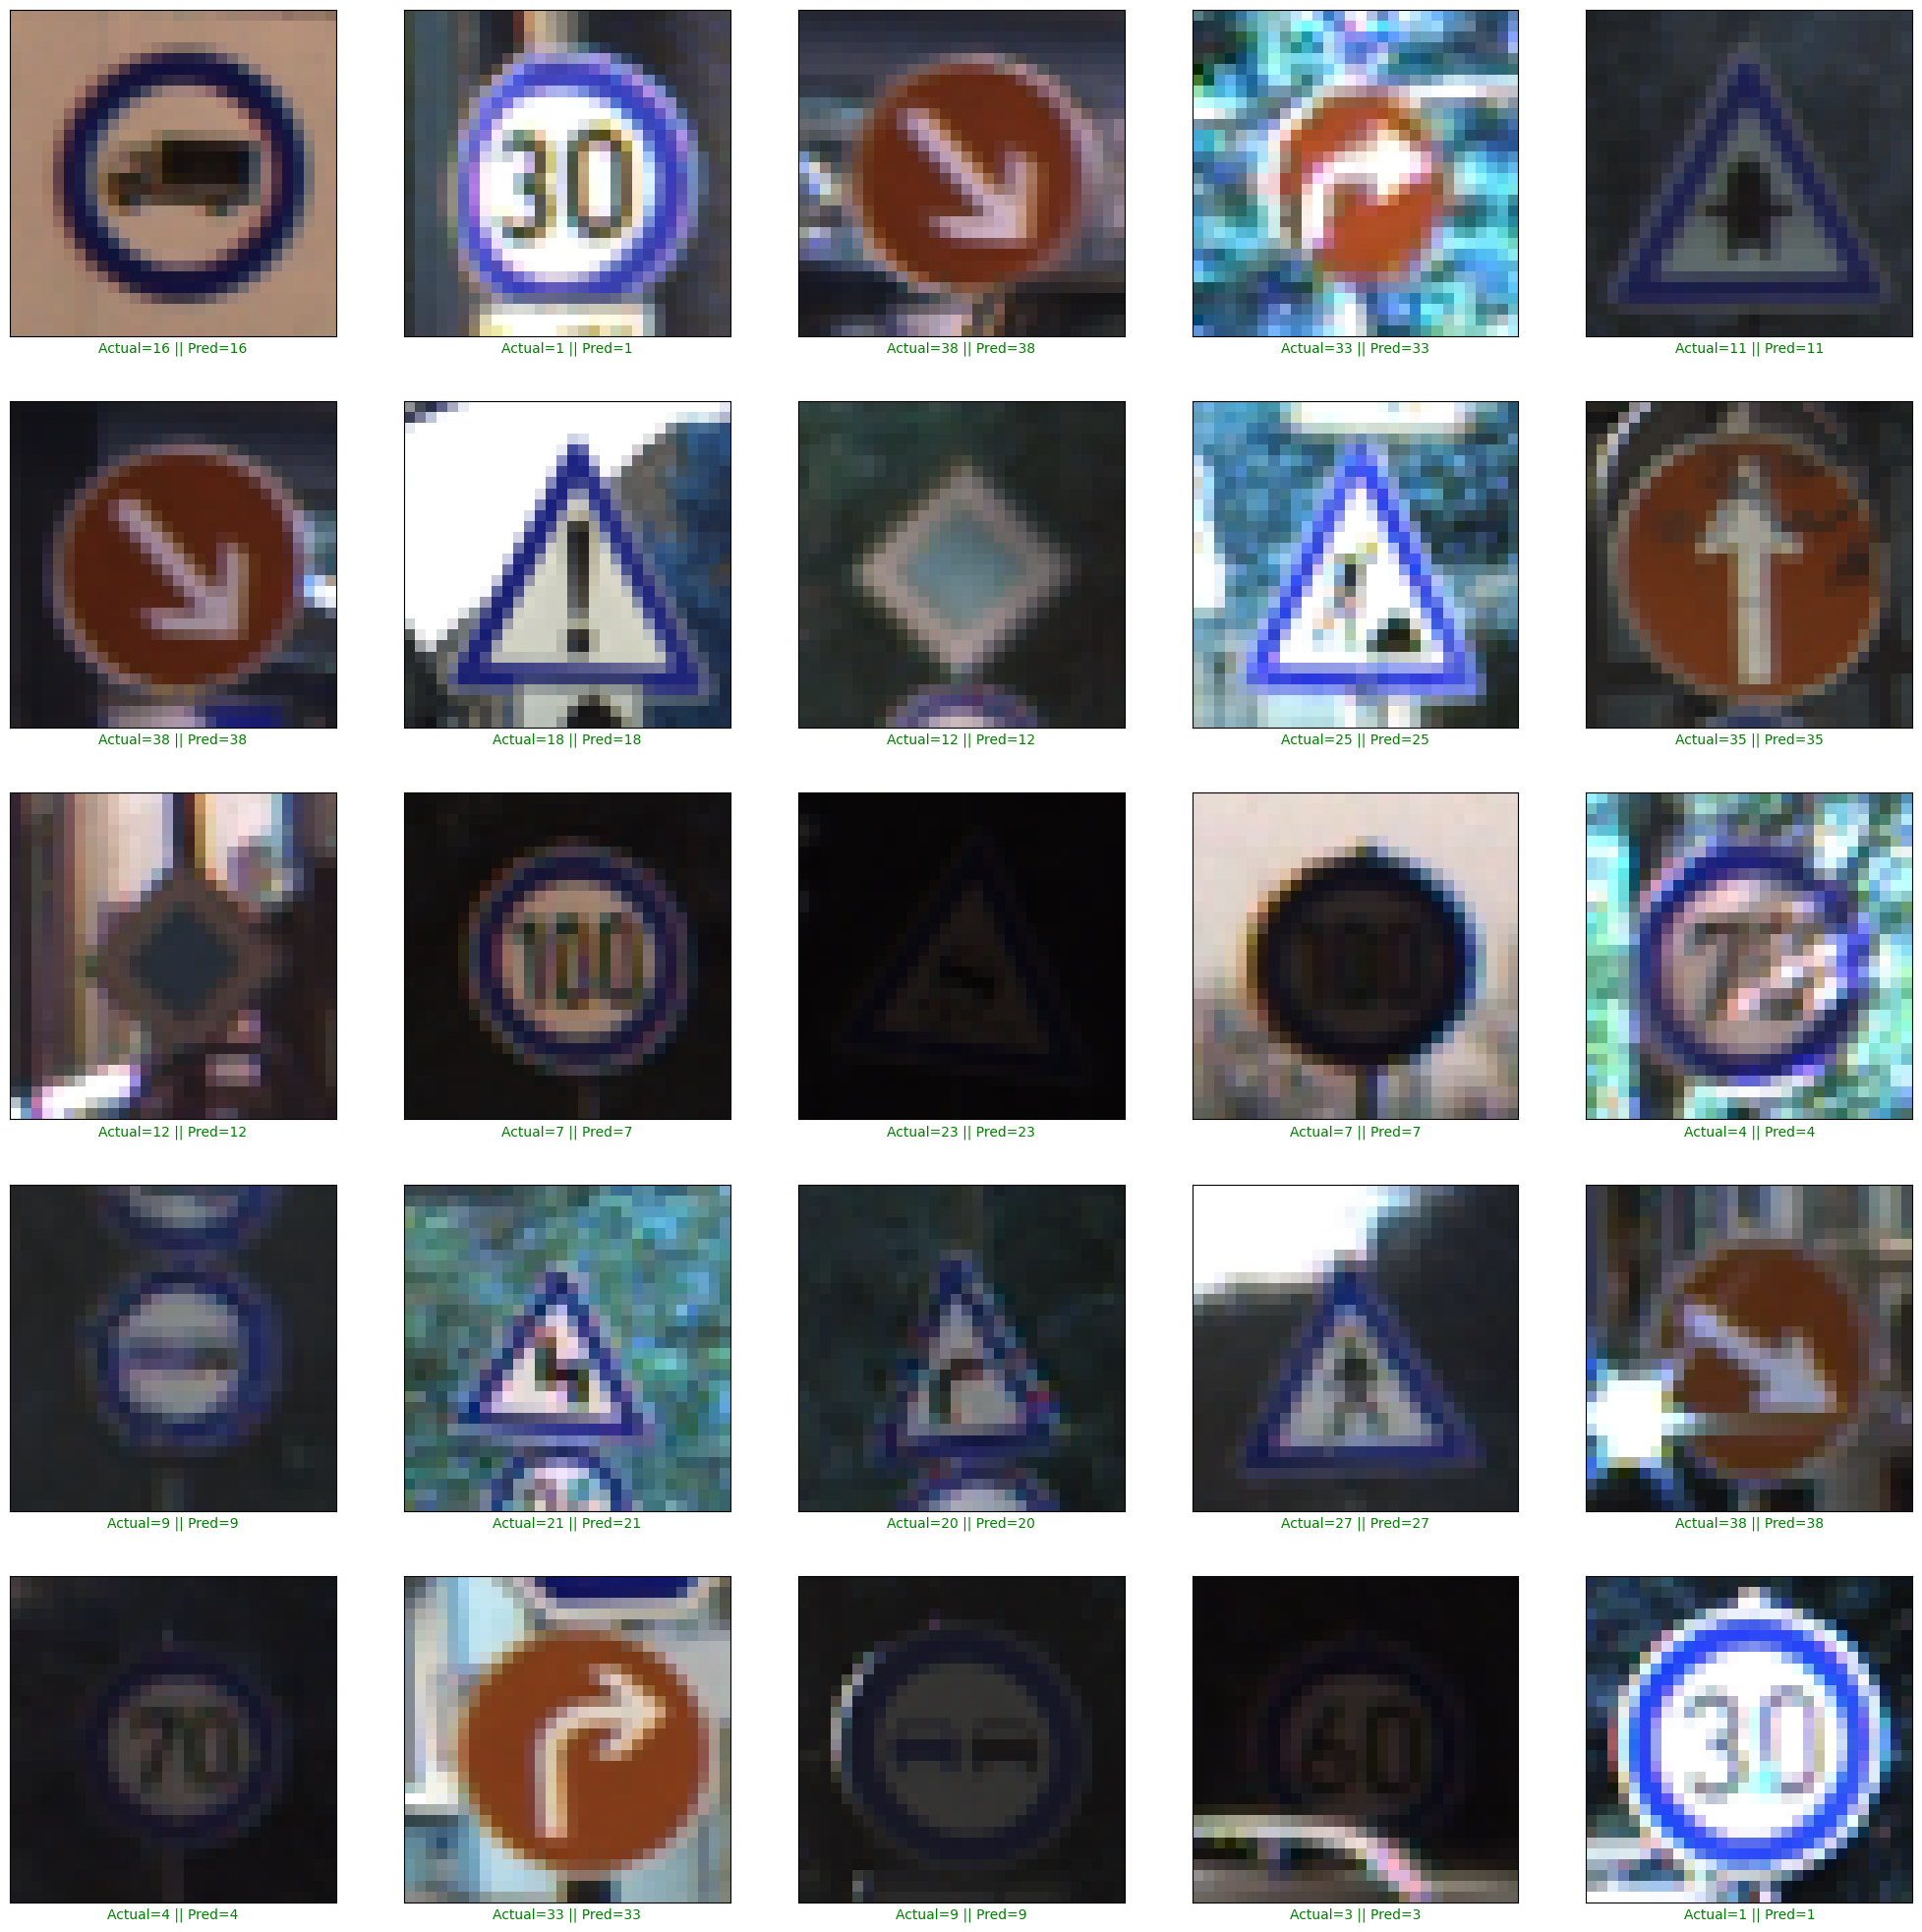

In [37]:
## Predictions on Test Data
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [38]:
model.save("Traffic_sign_class_model.h5")

In [39]:
model.save_weights("/content/gtsrb-german-traffic-sign/output")